# Lab 4
## CartPole with Value-Based Agents (DQN Variants)

Objectives:
1. Train a **baseline DQN** on CartPole using **RL Zoo 3** (a training harness around Stable-Baselines3).
2. Diagnose **stability** by inspecting learning curves and evaluation performance.
3. Implement and train **Dueling DQN** (an architecture change) using Stable-Baselines3 directly.
4. On your own, implemnet **Double DQN**




Run on Google Colab:

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/duke-trust-lab/intro_modern_rl/blob/main/lab4/lab4.ipynb)

In [ ]:
%pip install -q stable-baselines3==2.* sb3-contrib==2.* gymnasium matplotlib pandas pyyaml imageio ffmpeg-python
%pip install -q rl_zoo3

In [ ]:
import os
import glob
import time
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import Video, display

import gymnasium as gym
import torch

### What DQN is doing

DQN learns an approximation of the action-value function:

Qθ(s,a)

A standard DQN target is:

y = r + γ max_a' Qθ⁻(s', a')

where:
- θ: online network parameters (updated every gradient step)
- θ⁻: target network parameters (updated more slowly)

DQN typically uses:
- **experience replay**: sample random mini-batches from a replay buffer (reduces correlation)
- **target network**: stabilizes the moving target in TD learning
- **ε-greedy exploration**: balance exploration vs exploitation

---

## Why use RL Zoo 3 for the baseline run?

RL Zoo provides:
- a clean, repeatable CLI training workflow
- standardized logging + saved best models
- video recording utilities

This lets us focus on:
- what the hyperparameters mean
- what the training curves tell us
- how evaluation differs from training


### Create RL Zoo YAML config for baseline DQN

In [ ]:
ENV_ID = "CartPole-v1"
LOG_DIR = "logs"

os.makedirs(LOG_DIR, exist_ok=True)

dqn_config = {
    ENV_ID: {
        "policy": "MlpPolicy",
        "n_timesteps": float(6e4),
        "buffer_size": 20000,
        "learning_starts": 1000,
        "target_update_interval": 250,
        "exploration_fraction": 0.2,
        "exploration_final_eps": 0.06,
        "learning_rate": float(1e-3),
        "batch_size": 64,
        "train_freq": 32,
        "gradient_steps": 16,
        "gamma": 0.99,
        "optimize_memory_usage": False,
    }
}

with open("dqn_base.yaml", "w") as f:
    yaml.safe_dump(dqn_config, f, sort_keys=False)

print("Wrote dqn_base.yaml")

In [ ]:
# Train a single baseline run (seed 0). You can later expand to multiple seeds.
seed = 0
cmd = f"python -m rl_zoo3.train --algo dqn --env {ENV_ID} -f {LOG_DIR}/ -c dqn_base.yaml --log-interval 1000 --seed {seed}"
print("Running:", cmd)
!{cmd}

In [ ]:
cmd = f"""python -m rl_zoo3.record_video \
  --algo dqn \
  --env {ENV_ID} \
  --folder {LOG_DIR}/ \
  -n 600 \
  --deterministic \
  --load-best
"""
print("Running:", cmd)
!{cmd}

In [ ]:
mp4s = glob.glob(os.path.join(LOG_DIR, "**", "*.mp4"), recursive=True)
mp4s_sorted = sorted(mp4s, key=os.path.getmtime, reverse=True)
print("Found videos:", len(mp4s_sorted))

if mp4s_sorted:
    print("Showing:", mp4s_sorted[0])
    display(Video(mp4s_sorted[0], embed=True))

## Diagnosing value estimation instability

In deep value-based RL, instability can show up as:
- learning curves that spike then collapse
- large oscillations in evaluation returns
- sensitivity to seed / hyperparameters
- apparently “good” training signals that don’t transfer to evaluation behavior



### Dueling DQN

Dueling DQN explicitly decomposes:

Q(s,a) = V(s) + A(s,a) − mean_a A(s,a)

Intuition:
- V(s): how good is the state (regardless of action)?
- A(s,a): how much better is action a compared to other actions in state s?

This can help in environments where:
- many actions have similar value
- learning V(s) is easier than learning full Q(s,a) directly

We will implement a custom DQN policy with dueling heads.


In [ ]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback

SB3_LOG_BASE = "sb3_logs"
os.makedirs(SB3_LOG_BASE, exist_ok=True)

def make_env(env_id="CartPole-v1"):
    env = gym.make(env_id)
    env = Monitor(env)
    return env

def train_sb3(
    name: str,
    policy,
    env_id="CartPole-v1",
    total_timesteps=60_000,
    seed=0,
    policy_kwargs=None,
):
    env = make_env(env_id)
    eval_env = make_env(env_id)

    run_dir = os.path.join(SB3_LOG_BASE, name)
    os.makedirs(run_dir, exist_ok=True)

    eval_callback = EvalCallback(
        eval_env,
        best_model_save_path=run_dir,
        log_path=run_dir,
        eval_freq=10_000,
        deterministic=True,
        render=False,
    )

    model = DQN(
        policy,
        env,
        learning_rate=1e-3,
        buffer_size=20_000,
        learning_starts=1_000,
        batch_size=64,
        tau=1.0,                  # hard target updates
        target_update_interval=250,
        train_freq=32,
        gradient_steps=16,
        gamma=0.99,
        exploration_fraction=0.2,
        exploration_final_eps=0.06,
        policy_kwargs=policy_kwargs,
        verbose=0,
        seed=seed,
        device="cuda" if torch.cuda.is_available() else "cpu",
    )

    model.learn(total_timesteps=total_timesteps, callback=eval_callback)
    model.save(os.path.join(run_dir, "final_model"))
    return run_dir

### Define Dueling DQN policy

In [ ]:
import torch.nn as nn
from stable_baselines3.dqn.policies import DQNPolicy, QNetwork

class DuelingQNetwork(QNetwork):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        hidden_dim = 256

        self.shared = nn.Sequential(
            nn.Linear(self.features_dim, hidden_dim),
            nn.ReLU(),
        )

        # Value head V(s)
        self.V = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )

        # Advantage head A(s,a)
        self.A = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.action_space.n),
        )

    def forward(self, obs):
        features = self.extract_features(obs, self.features_extractor)
        h = self.shared(features)
        v = self.V(h)                          # [batch, 1]
        a = self.A(h)                          # [batch, n_actions]
        q = v + (a - a.mean(dim=1, keepdim=True))
        return q

class DuelingDQNPolicy(DQNPolicy):
    def make_q_net(self):
        net_args = self._update_features_extractor(self.net_args, features_extractor=None)
        return DuelingQNetwork(**net_args).to(self.device)

### Train baseline SB3 DQN + Dueling DQN

In [ ]:
seed = 0
sb3_baseline_dir = train_sb3("dqn_baseline_seed0", policy="MlpPolicy", seed=seed)
sb3_dueling_dir  = train_sb3("dqn_dueling_seed0",  policy=DuelingDQNPolicy, seed=seed)

sb3_baseline_dir, sb3_dueling_dir

### SB3 eval curves

In [ ]:
def load_eval_npz(run_dir):
    npz_path = os.path.join(run_dir, "evaluations.npz")
    if not os.path.exists(npz_path):
        return None
    data = np.load(npz_path)
    timesteps = data["timesteps"]
    results = data["results"]          # shape [n_evals, n_episodes]
    mean_reward = results.mean(axis=1)
    return pd.DataFrame({"timesteps": timesteps, "mean_reward": mean_reward})

b = load_eval_npz(sb3_baseline_dir)
d = load_eval_npz(sb3_dueling_dir)

plt.figure()
if b is not None:
    plt.plot(b["timesteps"], b["mean_reward"], label="SB3 DQN baseline")
if d is not None:
    plt.plot(d["timesteps"], d["mean_reward"], label="SB3 Dueling DQN")
plt.xlabel("timesteps")
plt.ylabel("eval mean reward")
plt.title("Evaluation Performance: Baseline vs Dueling")
plt.legend()
plt.show()

In [ ]:
import os
import imageio
import gymnasium as gym
import numpy as np

from stable_baselines3 import DQN

def record_sb3_rollout_mp4(
    model_zip_path: str,
    out_mp4_path: str,
    env_id: str = "CartPole-v1",
    n_steps: int = 600,          # 600 frames at 30 fps = 20 seconds
    fps: int = 30,
    deterministic: bool = True,
):
    os.makedirs(os.path.dirname(out_mp4_path), exist_ok=True)

    env = gym.make(env_id, render_mode="rgb_array")
    model = DQN.load(model_zip_path)

    obs, info = env.reset()
    frames = []

    for _ in range(n_steps):
        frame = env.render()
        frames.append(frame)

        action, _ = model.predict(obs, deterministic=deterministic)
        obs, reward, terminated, truncated, info = env.step(action)

        if terminated or truncated:
            obs, info = env.reset()

    env.close()

    imageio.mimsave(out_mp4_path, frames, fps=fps)
    return out_mp4_path


In [ ]:
baseline_mp4 = record_sb3_rollout_mp4(
    model_zip_path=os.path.join(sb3_baseline_dir, "best_model.zip"),
    out_mp4_path=os.path.join(sb3_baseline_dir, "videos_manual", "baseline.mp4"),
    n_steps=600,
    fps=30,
)

dueling_mp4 = record_sb3_rollout_mp4(
    model_zip_path=os.path.join(sb3_dueling_dir, "best_model.zip"),
    out_mp4_path=os.path.join(sb3_dueling_dir, "videos_manual", "dueling.mp4"),
    n_steps=600,
    fps=30,
)

baseline_mp4, dueling_mp4


In [ ]:
from IPython.display import Video, display

display(Video(baseline_mp4, embed=True))
display(Video(dueling_mp4, embed=True))

### Checkpoint

**What happened?**


Dueling DQN learns faster at first because it can more easily estimate which states are good. But that same decomposition makes it more sensitive to noisy value estimates. Without Double DQN or careful tuning, those errors can compound and cause instability. Baseline DQN is slower but more robust here, which is why simple methods often outperform more advanced ones on small problems


### Double DQN

A common failure mode in value-based RL is **overestimation bias**.

Why?
- Q-values are learned estimates and are noisy.
- Taking `max_a Q(s,a)` tends to select actions with positive noise.

Baseline DQN target:
y = r + γ max_a' Qθ⁻(s', a')

Double DQN target (key idea: decouple selection and evaluation):
1) select action using online net:
   a* = argmax_a' Qθ(s', a')

2) evaluate that action using target net:
   y = r + γ Qθ⁻(s', a*)

This reduces maximization bias and often improves stability.

### TODO
- Implement Double DQN
- Plot evaluation of Baseline v. Dueling v. Double DQN


In [65]:
import torch.nn.functional as F
from stable_baselines3.common.type_aliases import ReplayBufferSamples

class DoubleDQN(DQN):
    def train(self, gradient_steps: int, batch_size: int = 100):
        self.policy.set_training_mode(True)
        self._update_learning_rate(self.policy.optimizer)

        losses = []
        for _ in range(gradient_steps):
            self._n_updates += 1
            replay_data = self.replay_buffer.sample(batch_size, env=self._vec_normalize_env)

            with torch.no_grad():
                # Double DQN: select action with online network
                next_q_values_online = self.q_net(replay_data.next_observations)
                next_actions = next_q_values_online.argmax(dim=1, keepdim=True)

                # Evaluate selected action with target network
                next_q_values_target = self.q_net_target(replay_data.next_observations)
                next_q_values = next_q_values_target.gather(1, next_actions).squeeze()

                target_q_values = replay_data.rewards + (1 - replay_data.dones) * self.gamma * next_q_values

            current_q_values = self.q_net(replay_data.observations).gather(1, replay_data.actions).squeeze()
            loss = F.mse_loss(current_q_values, target_q_values)
            losses.append(loss.item())

            self.policy.optimizer.zero_grad()
            loss.backward()
            if self.max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
            self.policy.optimizer.step()

        if self._n_updates % self.target_update_interval == 0:
            self.q_net_target.load_state_dict(self.q_net.state_dict())

        self._on_step()
        return losses

In [67]:
def train_double_dqn(
    name: str,
    policy,
    env_id="CartPole-v1",
    total_timesteps=60_000,
    seed=0,
    policy_kwargs=None,
):
    env = make_env(env_id)
    eval_env = make_env(env_id)

    run_dir = os.path.join(SB3_LOG_BASE, name)
    os.makedirs(run_dir, exist_ok=True)

    eval_callback = EvalCallback(
        eval_env,
        best_model_save_path=run_dir,
        log_path=run_dir,
        eval_freq=10_000,
        deterministic=True,
        render=False,
    )

    model = DoubleDQN(
        policy,
        env,
        learning_rate=1e-3,
        buffer_size=20_000,
        learning_starts=1_000,
        batch_size=64,
        tau=1.0,
        target_update_interval=250,
        train_freq=32,
        gradient_steps=16,
        gamma=0.99,
        exploration_fraction=0.2,
        exploration_final_eps=0.06,
        policy_kwargs=policy_kwargs,
        verbose=0,
        seed=seed,
        device="cuda" if torch.cuda.is_available() else "cpu",
    )

    model.learn(total_timesteps=total_timesteps, callback=eval_callback)
    model.save(os.path.join(run_dir, "final_model"))
    return run_dir

seed = 0
sb3_double_dir = train_double_dqn("dqn_double_seed0", policy="MlpPolicy", seed=seed)
sb3_double_dir

/tmp/ipython-input-2696038088.py:26: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(current_q_values, target_q_values)


Eval num_timesteps=10000, episode_reward=9.60 +/- 0.49
Episode length: 9.60 +/- 0.49
New best mean reward!
Eval num_timesteps=20000, episode_reward=9.40 +/- 0.49
Episode length: 9.40 +/- 0.49
Eval num_timesteps=30000, episode_reward=9.80 +/- 0.75
Episode length: 9.80 +/- 0.75
New best mean reward!
Eval num_timesteps=40000, episode_reward=9.00 +/- 0.63
Episode length: 9.00 +/- 0.63
Eval num_timesteps=50000, episode_reward=9.60 +/- 0.49
Episode length: 9.60 +/- 0.49
Eval num_timesteps=60000, episode_reward=9.60 +/- 0.49
Episode length: 9.60 +/- 0.49


'sb3_logs/dqn_double_seed0'

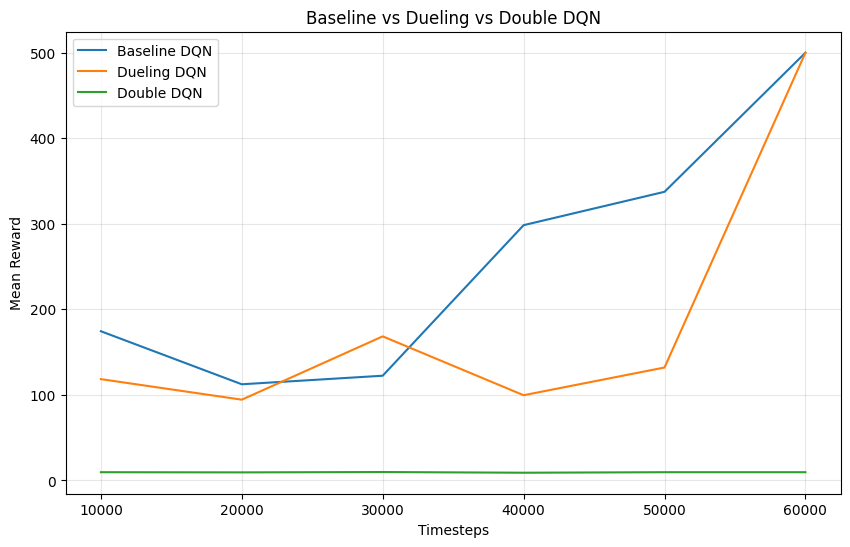

In [68]:
b = load_eval_npz(sb3_baseline_dir)
d = load_eval_npz(sb3_dueling_dir)
dd = load_eval_npz(sb3_double_dir)

plt.figure(figsize=(10, 6))
if b is not None:
    plt.plot(b["timesteps"], b["mean_reward"], label="Baseline DQN")
if d is not None:
    plt.plot(d["timesteps"], d["mean_reward"], label="Dueling DQN")
if dd is not None:
    plt.plot(dd["timesteps"], dd["mean_reward"], label="Double DQN")
plt.xlabel("Timesteps")
plt.ylabel("Mean Reward")
plt.title("Baseline vs Dueling vs Double DQN")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()